## Sampling from a langue model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/03_sampling_lmm.ipynb)

The following NB demonstrates the sampling from a causal LLM, like the GPT models.

The idea is to generate a sequence of tokens, one at a time, by sampling from the conditional distribution of the next token given the previous ones. This is done by sampling from the output of the model, which is a probability distribution over the vocabulary.

We start by using very small GTP-2 Models from the `transformers` library of Hugging Face. If you want to use a larger model, you can change the `model_name` to more powerful models like:

* "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" 




In [1]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] ="torch"
import keras
import torch
print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

# Keras Building blocks
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Input
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch


In [2]:
import time

## Tokenization

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load pretrained model and tokenizer
#model_name = "tiiuae/falcon-7b-instruct" #High mem confing runs ok
#model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" #For math OK
model_name = "gpt2-medium" #Runs on standard Colab Instances
model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" #Quite slow on mac

tokenizer = AutoTokenizer.from_pretrained(model_name)
input_context = "Hello World Hund"
torch.tensor(tokenizer.encode(input_context))
# For GPT2 Tokenization
# 15496 is for 'Hello ' note the trailing white space
#  2159 is for ' World' note the leading white space
#   367 is for ' H'
#   917 is for 'und'

tensor([128000,   9906,   4435,  99014])

In [4]:
tokenizer.decode([367, 917])

'ation app'

## Downloading model

In [5]:
model = AutoModelForCausalLM.from_pretrained(model_name)
model.num_parameters() / (1E9) #In Billions note that GPT 3.5 has 175B
# This may take a while to download the model 
#   gpt2-medium ~16 Seconds in University Network

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

8.030261248

In [6]:
#model = AutoModelForCausalLM.from_pretrained(model_name)
input_context = "The weather is really nice today. I'm thinking about going for a"
input_ids = torch.tensor(tokenizer.encode(input_context)).unsqueeze(0)
input_ids, input_ids.shape

(tensor([[128000,    791,   9282,    374,   2216,   6555,   3432,     13,    358,
            2846,   7422,    922,   2133,    369,    264]]),
 torch.Size([1, 15]))

## Predicting the next token

In [7]:

start_time = time.time()
outputs = model(input_ids) # We ask the model for the next token
end_time = time.time()

time_next_token = end_time - start_time
print(f"Execution Time: {time_next_token:.3f} seconds")

Execution Time: 172.661 seconds


In [8]:
outputs.logits.shape
# We have 14 entries
# Fhe first are the logits of the next token after 'The'
# The second are the logits of the next token after 'The weather'
# ...
# The last is the next token after 'The weather is really nice today. I'm thinking about going for a'
# This is the only one which matters

torch.Size([1, 15, 128256])

In [9]:
with torch.no_grad():
    next_token_logits = outputs.logits[:, -1, :]
next_token_logits.shape, next_token_logits

(torch.Size([1, 128256]),
 tensor([[ 4.3394,  1.0772,  0.7788,  ..., -2.6558, -2.6562, -2.6563]],
        requires_grad=True))

In [10]:
probs = torch.nn.functional.softmax(next_token_logits, dim=-1)[0]
probs, probs.shape

(tensor([6.2301e-07, 2.3864e-08, 1.7708e-08,  ..., 5.7085e-10, 5.7062e-10,
         5.7058e-10], grad_fn=<SelectBackward0>),
 torch.Size([128256]))

In [11]:
# Find the indices that would sort the probabilities in descending order
sorted_indices = torch.argsort(probs, dim=-1, descending=True)
top_indices = sorted_indices[:10]

cumulative_prob = 0
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  cumulative_prob += probability
  print(f"Token: '{token}', Probability: {probability}, Cummulative: {cumulative_prob}")

Token: ' walk', Probability: 0.7398812174797058, Cummulative: 0.7398812174797058
Token: ' bike', Probability: 0.0887528508901596, Cummulative: 0.8286340683698654
Token: ' run', Probability: 0.0597018301486969, Cummulative: 0.8883358985185623
Token: ' long', Probability: 0.030196523293852806, Cummulative: 0.9185324218124151
Token: ' hike', Probability: 0.014443833380937576, Cummulative: 0.9329762551933527
Token: ' short', Probability: 0.013412346132099628, Cummulative: 0.9463886013254523
Token: ' drive', Probability: 0.010132350958883762, Cummulative: 0.9565209522843361
Token: ' jog', Probability: 0.009219041094183922, Cummulative: 0.96573999337852
Token: ' nice', Probability: 0.006652022246271372, Cummulative: 0.9723920156247914
Token: ' solo', Probability: 0.004193985369056463, Cummulative: 0.9765860009938478


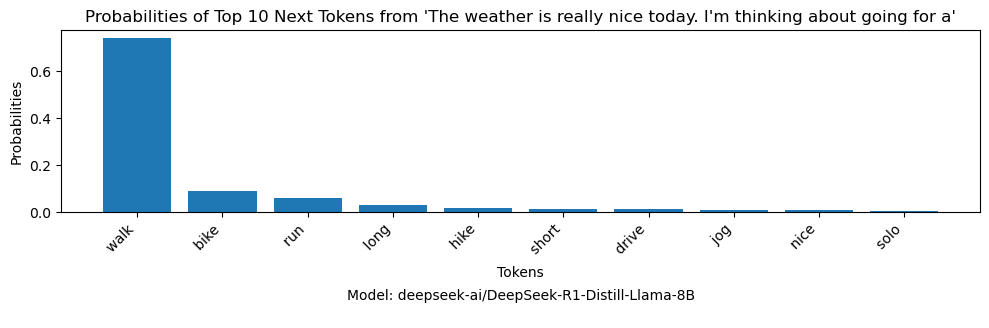

In [12]:
import matplotlib.pyplot as plt
top_indices = sorted_indices[:10]

tokens = []
probabilities = []
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  tokens.append(token)
  probabilities.append(probability)


# 
# Add dataset information as text within the plot
text_info = f"Model: {model_name}\n"
text_info


plt.figure(figsize=(10, 3))
plt.bar(tokens, probabilities)
plt.xlabel("Tokens")
plt.ylabel("Probabilities")
plt.title(f"Probabilities of Top 10 Next Tokens from '{input_context}'")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.text(0.5, -0.5, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show()


## Sampling a sequence

### Basic Idea to sample t

In [13]:
from torch.distributions import Categorical
from collections import Counter

# Create a categorical distribution based on the logits
categorical_dist = Categorical(logits=next_token_logits)

# Sample from the distribution
sampled_index = categorical_dist.sample()

# Decode the sampled index to get the actual token
sampled_token = tokenizer.decode(sampled_index.item())
print("Sampled token:", sampled_token)

Sampled token:  walk


In [14]:
sampled_tokens = []
for _ in range(100):
    sampled_index = categorical_dist.sample()
    sampled_token = tokenizer.decode(sampled_index.item())
    sampled_tokens.append(sampled_token)

# Create a frequency table
frequency_table = Counter(sampled_tokens)

# Sort the frequency table by frequency in descending order
sorted_frequency_table = dict(sorted(frequency_table.items(), key=lambda item: item[1], reverse=True))

# Display the top-5 frequencies
for token, freq in list(sorted_frequency_table.items())[:10]:
    print(f"Token: '{token}', Frequency: {freq}")

Token: ' walk', Frequency: 80
Token: ' bike', Frequency: 9
Token: ' solo', Frequency: 2
Token: ' long', Frequency: 2
Token: ' nice', Frequency: 2
Token: ' run', Frequency: 2
Token: ' drive', Frequency: 1
Token: ' stroll', Frequency: 1
Token: ' picnic', Frequency: 1


In [ ]:
# Input context
input_context = "The weather is really nice today. I'm thinking about going for a"
input_context = "What is seq(1,10,0.1) in python"
input_context = "x^16/x^4"
input_context = "What is the capital of France."


input_ids = torch.tensor(tokenizer.encode(input_context)).unsqueeze(0)

# EOS token ID
eos_token_id = tokenizer.eos_token_id


# Function to sample the next token
def sample_next_token(input_ids):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(input_ids)
    next_token_logits = outputs.logits[:, -1, :]
    temperature = 0.1
    scaled_logits = next_token_logits / temperature
    categorical_dist = Categorical(logits=scaled_logits)
    sampled_index = categorical_dist.sample()
    return sampled_index.item()

# Generate text until EOS token is reached
generated_text = input_context 
num_tokens_to_generate = 50  # Max tokens to generate if EOS not encountered

for i in range(num_tokens_to_generate):
    sampled_token_index = sample_next_token(input_ids)

    # Check if EOS token is generated
    if sampled_token_index == eos_token_id:
        print("\n[End of Sequence Token Generated]")
        break

    sampled_token = tokenizer.decode([sampled_token_index], clean_up_tokenization_spaces=True)

    # Immediately display the next predicted token
    print(f"{i} Next token: '{sampled_token}'")

    generated_text += sampled_token
    input_ids = torch.cat([input_ids, torch.tensor([[sampled_token_index]])], dim=1)

print("\nGenerated Text:", generated_text)

0 Next token: ' I'
1 Next token: ' think'
2 Next token: ' it'
3 Next token: ''s'
4 Next token: ' Paris'
5 Next token: '.'
6 Next token: ' Yeah'
7 Next token: ','
8 Next token: ' that'
9 Next token: ''s'


### 🔧 **YOUR TASK:**

- Change the temperature to lower values (but >=0) what do you observe? Also change the prompt to e.g. "What is the capital of France."

- If time, change model to a more powerfull model like: 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'